[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


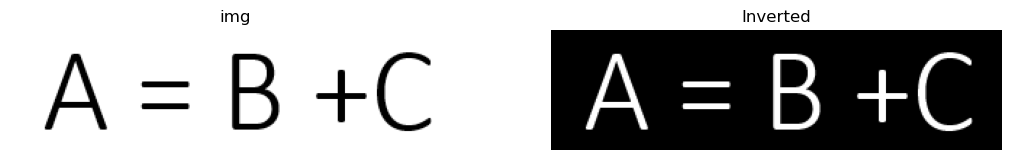

In [20]:
import commonfunctions as cf
from skimage.color import rgba2rgb

img  = io.imread('test_images/1.png')
img = rgba2rgb(img)
img = rgb2gray(img)

print(img)

img_inv = 1- img
show_images([img,img_inv],['img','Inverted'])

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
img = cv2.imread('test_images/1.png')

# convert to grayscale
gray = 255- cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# smooth the image to avoid noises
# gray = cv2.medianBlur(gray,5)
# Apply adaptive threshold
# thresh = cv2.adaptiveThreshold(gray, 255, 1, 1, 11, 2)
# thresh_color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# # apply some dilation and erosion to join the gaps
# kernel = np.ones((5,5), np.uint8)
# thresh = cv2.dilate(thresh, kernel ,iterations = 2)
# thresh = cv2.erode(thresh, kernel, iterations = 2)



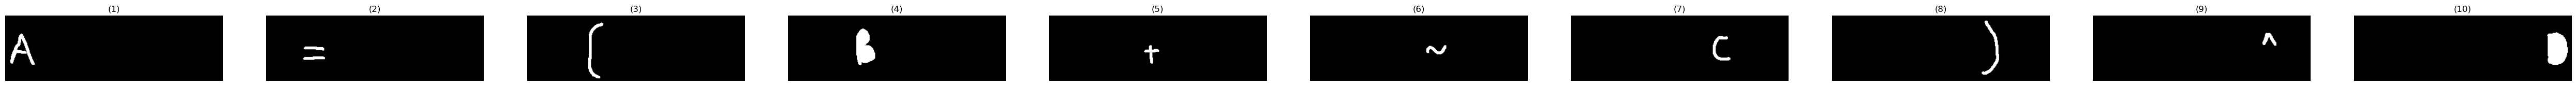

(320, 1064)


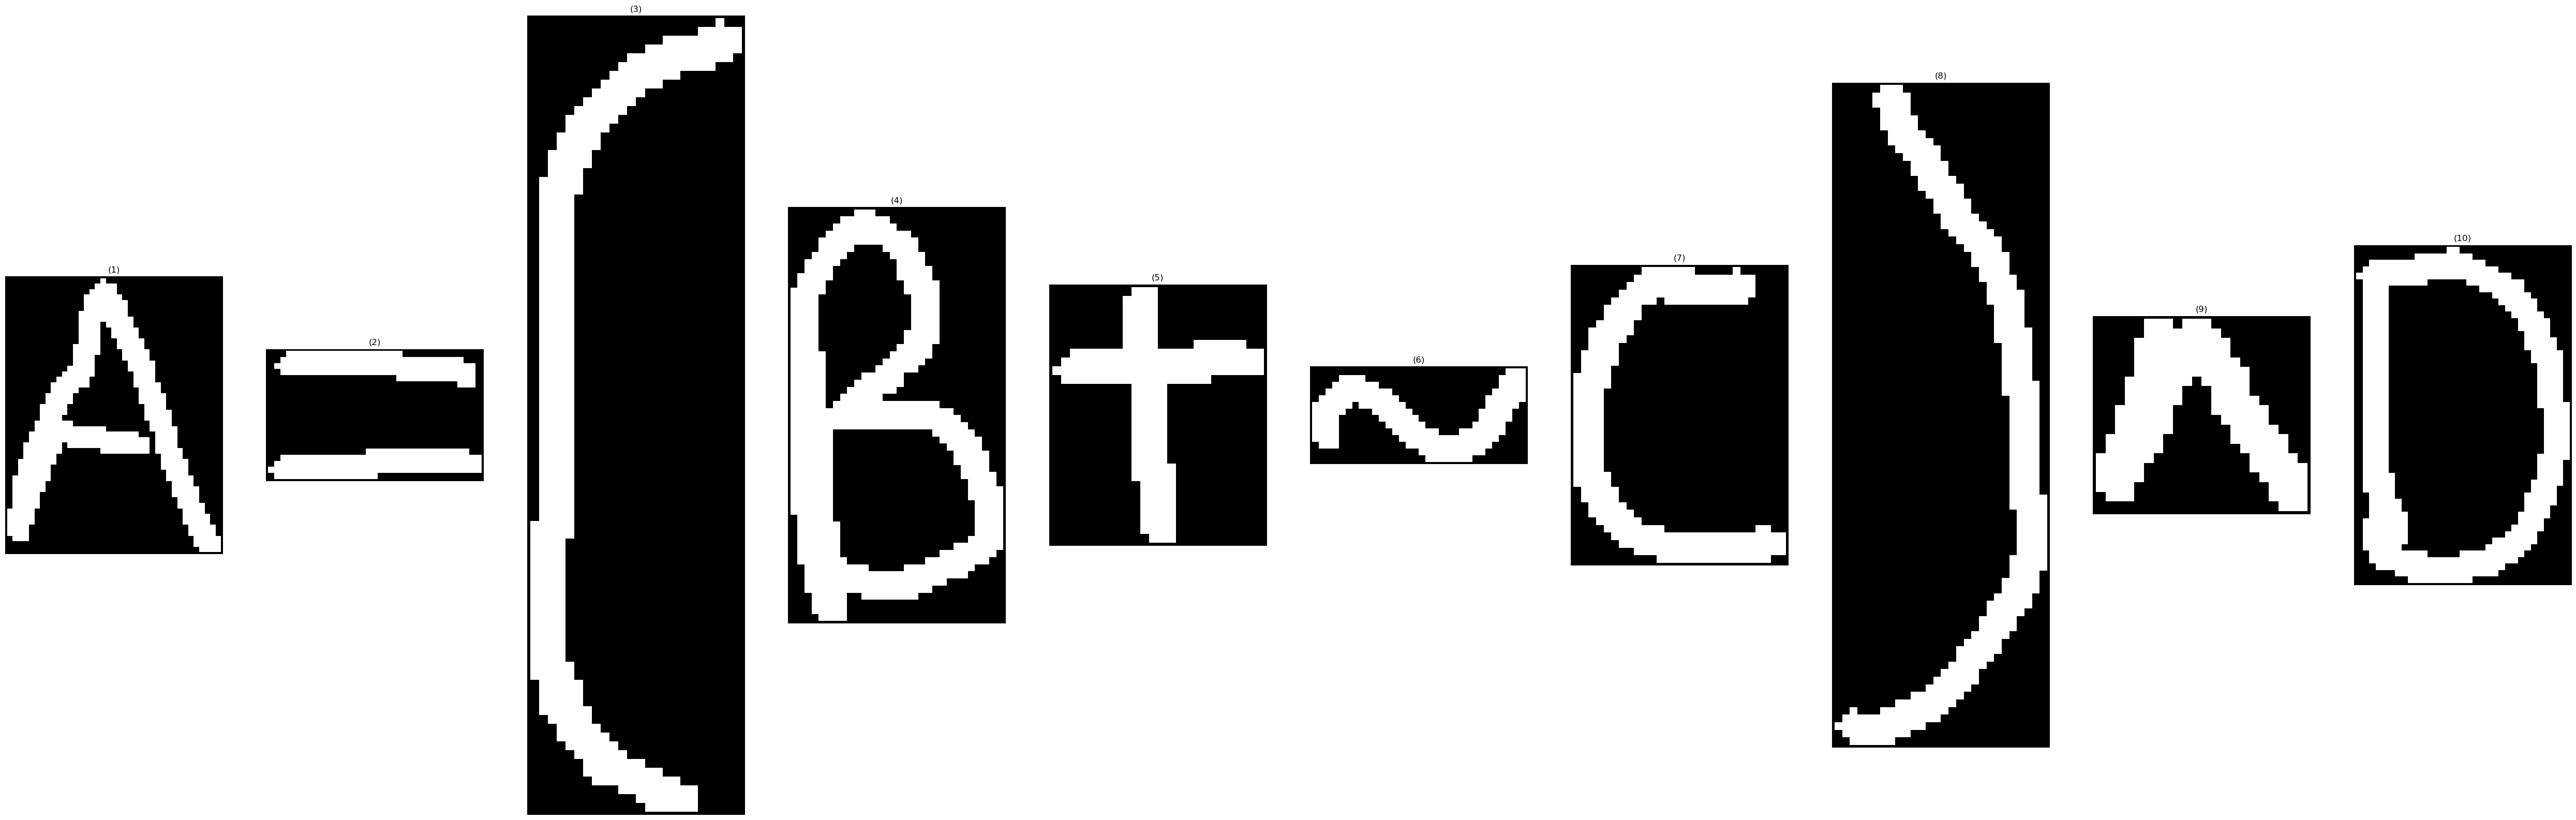

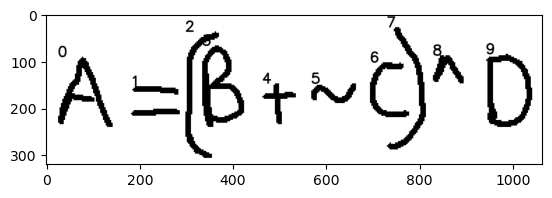

In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image

# convert to grayscale
img = 255- cv2.cvtColor(cv2.imread('test_images/3.png'), cv2.COLOR_BGR2GRAY)
h,w = img.shape
tolerance = 0.01 * w 
# Find the contours
contours,hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = list(filter(lambda cnt: cv2.contourArea(cnt,True) > 0 , contours))
# sort contours from left to right
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
# For each contour, find the bounding rectangle and draw it
contours_list = [(x,y,w,h) for x,y,w,h in [cv2.boundingRect(c) for c in contours]]


masks = []
for cont in contours:
    mask = np.zeros(img.shape, np.float32)
    cv2.drawContours(mask, [cont], 0, (1,1,1),-1)
    masks.append(mask)
    

#sort contours from left to right
# contours_list = sorted(contours_list, key=lambda ctr: ctr[0])


# merge list that are too close in x axis
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

for ind,(x,y,w,h) in enumerate(contours_list):
    prev_x = float('-inf') if ind == 0 else contours_list[ind-1][0]   
    if x - prev_x < tolerance:
        # merge contours 
        contours_list[ind] = union(contours_list[ind],contours_list[ind-1])
        contours_list.remove(contours_list[ind-1])
        # merge masks of the letters
        masks[ind] = masks[ind] + masks[ind-1]
        masks.pop(ind-1)
        ind -=1
        
  
cf.show_images(masks)
print(img.shape)
# For each contour, find the bounding rectangle and draw it
ret_images = []
for ind,(x,y,w,h) in enumerate(contours_list):
    new_img  = np.logical_and( ~img, masks[ind])[y:y+h,x:x+w]
    ret_images.append(new_img)
    # cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1) #crop 
    cv2.putText(img, str(ind), (x,y), cv2.FONT_ITALIC, 1, (0,0,255), 2, cv2.LINE_AA)
show_images(ret_images)
plt.imshow(img)
plt.show()

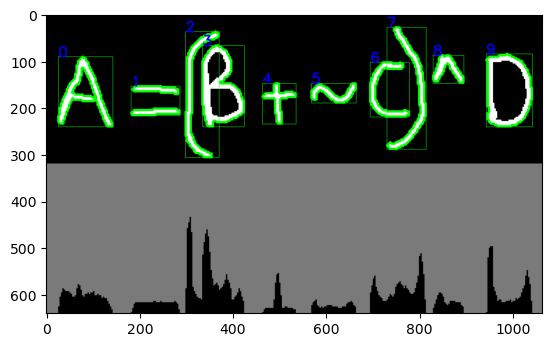

In [15]:
# Width and heigth the image
height, width = gray.shape
# Sum the value lines 
vertical_px = np.sum(gray, axis=0)
# Normalize
normalize = vertical_px/255
# create a black image with zeros 
blankImage = np.zeros_like(gray)
# Make the vertical projection histogram
for idx, value in enumerate(normalize):
    cv2.line(blankImage, (idx, 0), (idx, height-int(value)), (122,255,200), 1)
# Concatenate the image
img_concate = cv2.vconcat([img,  cv2.cvtColor(blankImage, cv2.COLOR_BGR2RGB)])

plt.imshow(img_concate)
plt.show()